In [12]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dropout, LSTM, Flatten, Dense, BatchNormalization
from keras.layers.convolutional import Conv1D, MaxPooling1D
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc
from sklearn.metrics import confusion_matrix

# Data Input and Model Creation

In [13]:
def normalize(data): 
    for i in data.columns:
        data[i] = (data[i] - np.mean(data[i]))/np.std(data[i])
    return np.nan_to_num(data)

In [14]:
"""
Function takes in preprocessed data (classes balanced, duplicates removed, NOT normalized)
The standard scaler has to be exported so it is important to normalize the data here

Change the paths in trainFull and TestFull to desired preprocessedData

"""
def getPreprocessedData():
    
    #Concatenate positive and negative samples
    trainFull = pd.read_csv("PreprocessedData/trainFull.csv")
    testFull = pd.read_csv("PreprocessedData/testFull.csv")

    trainFull = trainFull.sample(frac = 1)
    testFull = testFull.sample(frac = 1)
    
    #Reduce features and extract labels
    trainX = trainFull.iloc[:,:-1]
    trainY = trainFull.iloc[:,-1]
    testX = testFull.iloc[:,:-1]
    testY = testFull.iloc[:,-1]

    trainX = normalize(trainX)
    testX = normalize(testX)

    trainX = trainX[..., None]
    trainY = trainY.to_numpy()[..., None]
    testX = testX[..., None]
    testY = testY.to_numpy()[..., None]

    return trainX, trainY, testX, testY


In [15]:
"""
This method contains the architecture for the CNN used.
It uses tensorflow sequential as the basis to crease the model.

@param numConvFilters: number of convolutional filters in the 2nd hidden layer. We recommend >32 to upscale.
@param dropout: fraction of nodes dropped out of the Max Pooling layer.
@param numDenseNodes: number of dense nodes in the feed forward layer.

Recommended:
numConvFilters = 242
dropout = .215
numDenseNodes = 190

"""
def newModel(numConvFilters = 242, dropout = .215, numDenseNodes = 190):
    #Create new sequential model
    model = Sequential()

    #Add 1D Convolutional layers
    model.add((Conv1D(filters=32, kernel_size=3, activation='relu')))
    model.add((Conv1D(filters=numConvFilters, kernel_size=3, activation='relu')))
    #Add Max Pooling layer
    model.add((MaxPooling1D(pool_size=2)))
    #Apply dropout
    model.add(Dropout(dropout))
    #Flatten model
    model.add(Flatten())
    #Add fully connected dense layer
    model.add(Dense(numDenseNodes, activation='sigmoid'))
    #Add output node
    model.add(Dense(1, activation='sigmoid'))
    
    #Define optimizer
    adam = tf.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0)
    #Compile model
    model.compile(optimizer=adam, loss='binary_crossentropy', metrics=[tf.keras.metrics.AUC(curve='PR'),   
                                                                       tf.keras.metrics.PrecisionAtRecall(0.8)])
    return model

In [16]:
trainX, trainY, testX, testY = getPreprocessedData()
model = newModel()
model.fit(trainX, trainY, epochs = 30, batch_size=20, verbose = 1)

Epoch 1/30
758/758 [==============================] - 20s 25ms/step - loss: 0.5745 - auc_3: 0.7666 - precision_at_recall_3: 0.6557
Epoch 2/30
758/758 [==============================] - 15s 20ms/step - loss: 0.5270 - auc_3: 0.8182 - precision_at_recall_3: 0.6867
Epoch 3/30
758/758 [==============================] - 15s 20ms/step - loss: 0.5067 - auc_3: 0.8336 - precision_at_recall_3: 0.7103
Epoch 4/30
758/758 [==============================] - 17s 22ms/step - loss: 0.4924 - auc_3: 0.8443 - precision_at_recall_3: 0.7250
Epoch 5/30
758/758 [==============================] - 18s 24ms/step - loss: 0.4769 - auc_3: 0.8546 - precision_at_recall_3: 0.7389
Epoch 6/30
758/758 [==============================] - 19s 26ms/step - loss: 0.4647 - auc_3: 0.8629 - precision_at_recall_3: 0.7545
Epoch 7/30
758/758 [==============================] - 22s 30ms/step - loss: 0.4549 - auc_3: 0.8706 - precision_at_recall_3: 0.7656 3s - loss:
Epoch 8/30
758/758 [==============================] - 21s 27ms/step - lo

# Validation and Analysis 

In [17]:
#create confusion Matrix
def confusionMatrix(model, testX, testY):
    pred = model.predict(testX)
    predy = []
    for i in range(0,len(pred)):
        if pred[i] >= .5:
            predy.append(1)
        else:
            predy.append(0)
        
    print(confusion_matrix(testY,predy))
    
#Calculates our model metrics
def modelMetrics(testX, testY, model):
    y_scores = model.predict(testX)
    precision, recall, thresholds = precision_recall_curve(testY, y_scores)
    rec80 = np.max(recall[precision >= .8])
    print("Recall at 80% Precision: " +str(rec80))
    aucPR = auc(recall, precision)
    print("PR-AUC: " + str(aucPR))
    
    return rec80, aucPR, 

#plots a PR curve
def PRplot(testX, testY, model):
    y_scores = model.predict(testX)
    precision, recall, thresholds = precision_recall_curve(testY, y_scores)
    plt.plot(recall, precision)
    plt.title("PR curve")
    plt.xlabel("Recall")
    plt.ylabel("Precision")

Recall at 80% Precision: 0.8928759894459103
PR-AUC: 0.9170186100130359
[[1603  292]
 [ 328 1567]]


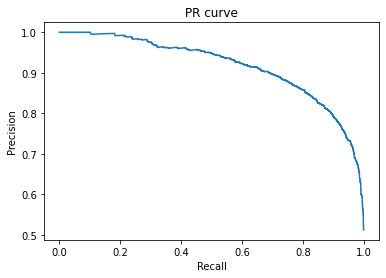

In [18]:
modelMetrics(testX, testY, model)
confusionMatrix(model, testX, testY)
PRplot(testX, testY, model)